In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import MolDraw2DCairo
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from torch_geometric.nn import GINConv, global_mean_pool
import random
from cairosvg import svg2png
from scipy.ndimage import gaussian_filter1d
import matplotlib.cm as cm
import matplotlib.colors as colors
from PIL import Image
from matplotlib.colors import TwoSlopeNorm
import tempfile
import io

In [2]:
# 定义超参数
N = 450
H_0 = 90
H_1 = 90
H_2 = 90
H_3 = 90
H_4 = 90
train_frac = 0.8
batch_size = 32
shuffle_seed = 0
learning_rate = 0.003
epochs = 1000
# 早停相关参数
patience = 10  # 当验证集损失在连续10个epoch没有下降时停止训练
best_val_loss = float('inf')
counter = 0


# 定义 Standardizer 类
class Standardizer:
    def __init__(self, X):
        self.mean = torch.mean(X)
        self.std = torch.std(X)

    def standardize(self, X):
        Z = (X - self.mean) / (self.std)
        return Z

    def restore(self, Z):
        X = self.mean + Z * self.std
        return X

    def state(self):
        return {"mean": self.mean, "std": self.std}

    def load(self, state):
        self.mean = state["mean"]
        self.std = state["std"]


# 定义 smiles_to_data 函数
def smiles_to_data(smiles, N=450):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES provided")

    # Adjacency Matrix
    adj = rdmolops.GetAdjacencyMatrix(mol, useBO=True)
    adj_matrix = np.zeros((N, N))
    s0, s1 = adj.shape
    if s0 > N:
        raise ValueError("Molecule too large")
    adj_matrix[:s0, :s1] = adj

    # Feature Matrix (One-hot encoding)
    atoms = mol.GetAtoms()
    n_atoms = 450
    node_mat = np.zeros((n_atoms, 90))
    for atom in atoms:
        atom_index = atom.GetIdx()
        atom_no = atom.GetAtomicNum()
        node_mat[atom_index, atom_no] = 1

    # Labels
    labels = []  # Assuming labels are not available in this function

    # Convert to PyTorch tensors
    X = torch.from_numpy(node_mat).float()
    A = torch.from_numpy(adj_matrix).float()
    y = torch.Tensor([[]]).float()  # Replace with actual labels if available
    mol_num = torch.Tensor([0])  # Assuming no molecular number available
    from scipy.sparse import coo_matrix
    A_coo = coo_matrix(A)
    edge_index = torch.from_numpy(np.vstack([A_coo.row, A_coo.col])).long()
    edge_weight = torch.from_numpy(A_coo.data).float()
    num_atoms = mol.GetNumAtoms()  # 获取实际原子数

    return Data(
        x=X,
        edge_index=edge_index,
        edge_attr=edge_weight,
        y=y,
        A=A,
        mol_num=mol_num,
        num_atoms=num_atoms,  # 新增属性
    )


# 定义 load_data 函数
def load_data(N=450):
    df = pd.read_csv('train.csv')
    dataset = []
    labels = []
    for index, row in df.iterrows():
        mol = Chem.MolFromSmiles(row.smiles)
        if mol is None:
            continue
        adj = rdmolops.GetAdjacencyMatrix(mol, useBO=True)
        s0, s1 = adj.shape
        if s0 > N:
            continue
        adj_matrix = np.zeros((N, N))
        adj_matrix[:s0, :s1] = adj

        atoms = mol.GetAtoms()
        n_atoms = 450
        node_mat = np.zeros((n_atoms, 90))
        for atom in atoms:
            atom_index = atom.GetIdx()
            atom_no = atom.GetAtomicNum()
            node_mat[atom_index, atom_no] = 1

        X = torch.from_numpy(node_mat).float()
        A = torch.from_numpy(adj_matrix).float()
        y = torch.tensor([row.energy]).float()
        mol_num = torch.tensor([row.num]).float()
        from scipy.sparse import coo_matrix
        A_coo = coo_matrix(A)
        edge_index = torch.from_numpy(np.vstack([A_coo.row, A_coo.col])).long()
        edge_weight = torch.from_numpy(A_coo.data).float()
        num_atoms = mol.GetNumAtoms()  # 获取实际原子数

        dataset.append(Data(
            x=X,
            edge_index=edge_index,
            edge_attr=edge_weight,
            y=y,
            A=A,
            mol_num=mol_num,
            num_atoms=num_atoms  # 新增属性
        ))
        labels.append(row.energy)
    return dataset


# 基于图同构网络（Graph Isomorphism Network, GIN）的神经网络模型
class GIN(torch.nn.Module):
    def __init__(self, H_0, H_1, H_2, H_3, H_4):
        super(GIN, self).__init__()

        # 4 层 GINConv
        self.conv1 = GINConv(torch.nn.Linear(H_0, H_1))
        self.conv2 = GINConv(torch.nn.Linear(H_1, H_2))
        self.conv3 = GINConv(torch.nn.Linear(H_2, H_3))
        self.conv4 = GINConv(torch.nn.Linear(H_3, H_4))

        self.fc1 = torch.nn.Linear(H_4, 32)  # 输入维度调整为 H_4
        # Modify the output unit to 1 for regression task
        self.fc2 = torch.nn.Linear(32, 1)

        self.activations = None
        self.gradients = None

    def forward(self, data):
        h0, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        h1 = F.elu(self.conv1(h0, edge_index))
        h2 = F.elu(self.conv2(h1, edge_index))
        h3 = F.elu(self.conv3(h2, edge_index))
        h4 = F.elu(self.conv4(h3, edge_index))

        # 保存激活值
        self.activations = h4

        # 注册钩子以捕获梯度
        def save_gradients(grad):
            self.gradients = grad

        if h4.requires_grad:
            h4.register_hook(save_gradients)

        h5 = global_mean_pool(h4, data.batch)
        h5 = F.elu(self.fc1(h5))

        out = self.fc2(h5)
        return out


# 定义 train 函数
def train(model, loader, device, optimizer, standardizer):
    model.train()
    total_loss = 0
    total_mae = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)

        y_std = standardizer.standardize(data.y.view(-1, 1))
        loss = F.mse_loss(out, y_std)

        mae = F.l1_loss(standardizer.restore(out), data.y.view(-1, 1))

        loss.backward()
        # 统计梯度方向
        total_positive = 0
        total_negative = 0
        for param in model.parameters():
            if param.grad is not None:
                total_positive += (param.grad > 0).sum().item()
                total_negative += (param.grad < 0).sum().item()
        
        total_loss += loss.item() * data.num_graphs
        total_mae += mae.item() * data.num_graphs

        optimizer.step()
    average_mae = total_mae / len(loader.dataset)
    average_loss = total_loss / len(loader.dataset)
    print(f'Train MAE: {average_mae:.4f}')
    return average_loss


# 定义 test 函数
def test(model, loader, device, standardizer):
    model.eval()
    total_loss = 0
    total_mae = 0
    all_y_true = []
    all_y_pred = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
            y_std = standardizer.standardize(data.y.view(-1, 1))

            total_loss += F.mse_loss(output, y_std, reduction='sum').item()
            total_mae += F.l1_loss(standardizer.restore(output),
                                   data.y.view(-1, 1), reduction='sum').item()

            all_y_true.append(data.y.view(-1, 1).cpu())
            all_y_pred.append(standardizer.restore(output).cpu())

    all_y_true = torch.cat(all_y_true, dim=0)
    all_y_pred = torch.cat(all_y_pred, dim=0)

    average_loss = total_loss / len(loader.dataset)
    average_mae = total_mae / len(loader.dataset)

    y_mean = all_y_true.mean()
    total_sum_of_squares = ((all_y_true - y_mean) ** 2).sum().item()
    residual_sum_of_squares = ((all_y_true - all_y_pred) ** 2).sum().item()
    r2_score = 1 - (residual_sum_of_squares / total_sum_of_squares)

    all_y_true_np = all_y_true.numpy().ravel()
    all_y_pred_np = all_y_pred.numpy().ravel()
    pearson_corr, _ = pearsonr(all_y_true_np, all_y_pred_np)

    print(f'Test MAE: {average_mae:.4f}')
    print(f'R² Score: {r2_score:.4f}')
    print(f'Pearson Correlation Coefficient: {pearson_corr:.4f}')

    return average_loss, average_mae, r2_score, pearson_corr, all_y_pred, all_y_true


# 修改后的预测函数
def predict(model, smiles, device, standardizer):
    data = smiles_to_data(smiles)
    # 自动生成batch属性
    loader = DataLoader([data], batch_size=1, shuffle=False)
    model.eval()
    with torch.no_grad():
        for data_in_loader in loader:
            data_in_loader = data_in_loader.to(device)
            output = model(data_in_loader)
    return standardizer.restore(output).item()


def compute_global_cam_stats(model, dataset, device):
    model.eval()
    all_cams = []
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for data in loader:
        data = data.to(device)
        model.zero_grad()
        output = model(data)
        output.backward()

        acts = model.activations.detach().cpu().numpy()
        grads = model.gradients.detach().cpu().numpy()
        num_atoms = data.num_atoms

        cam = grad_cam(acts, grads, num_atoms)
        all_cams.append(cam)

    all_cams = np.concatenate(all_cams)
    # 只考虑正向贡献的范围
    global_min = np.percentile(all_cams, 1)
    global_max = np.percentile(all_cams, 99)
    return global_min, global_max  # 不再取对称范围

def grad_cam(activations, gradients, num_atoms):
    if activations.ndim != 2 or gradients.ndim != 2:
        raise ValueError(f"输入应为二维数组，但获得：activations {activations.shape}，gradients {gradients.shape}")
    
    # 保持原始梯度计算（不再取符号）
    weights = np.mean(gradients, axis=0)
    cam = np.dot(activations, weights)
    cam = cam[:num_atoms] if len(cam) >= num_atoms else cam
    return gaussian_filter1d(cam, sigma=1.5)

def plot_atom_contributions(model, data, smiles, num_value, output_folder, global_min, global_max):
    mol = Chem.MolFromSmiles(smiles)
    num_atoms = data.num_atoms

    acts = model.activations.detach().cpu().numpy()
    grads = model.gradients.detach().cpu().numpy()

    atom_weights = grad_cam(acts, grads, num_atoms)
    
    # 线性映射到0-1范围
    atom_weights = (atom_weights - global_min) / (global_max - global_min)
    atom_weights = np.clip(atom_weights, 0, 1)  # 限制在[0,1]

    assert len(atom_weights) == num_atoms, f"权重数量{len(atom_weights)}与原子数{num_atoms}不匹配"

    img = visualize_atom_weights(mol, atom_weights)
    img_path = os.path.join(output_folder, f'{num_value}_atom_contributions.png')
    plt.imsave(img_path, img)

def visualize_atom_weights(mol, weights):
    assert len(weights) == mol.GetNumAtoms(), "权重数量与分子原子数不匹配"

    # 使用从蓝到红的双色渐变
    norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
    cmap = plt.get_cmap('bwr')

    drawer = MolDraw2DCairo(400, 400)
    rdDepictor.Compute2DCoords(mol)

    atom_colors = {}
    for i in range(len(weights)):
        color = cmap(norm(weights[i]))
        atom_colors[i] = (color[0], color[1], color[2], 0.7)  # 70%透明度

    # 渲染分子图像
    drawer.DrawMolecule(mol,
                        highlightAtoms=list(range(len(weights))),
                        highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    img = plt.imread(io.BytesIO(img_data))

    # 生成颜色条
    fig, ax = plt.subplots(figsize=(1, 4))
    im = ax.imshow(np.array([[0, 0.5, 1]]), cmap=cmap, norm=norm, aspect='auto')
    ax.set_visible(False)
    cbar = fig.colorbar(im, orientation='vertical', label='Promotion Effect', shrink=1)
    cbar.ax.set_ylabel('Promotion Strength', rotation=270, labelpad=15)

    # 处理颜色条图像
    colorbar_buffer = io.BytesIO()
    plt.savefig(colorbar_buffer, format='png', bbox_inches='tight')
    colorbar_buffer.seek(0)
    colorbar_img = plt.imread(colorbar_buffer)
    plt.close(fig)

    # 确保颜色条图像高度与分子图像一致
    if colorbar_img.shape[0] != img.shape[0]:
        colorbar_pil = Image.fromarray((colorbar_img * 255).astype(np.uint8))
        colorbar_pil = colorbar_pil.resize((colorbar_pil.width, img.shape[0]))
        colorbar_img = np.array(colorbar_pil) / 255

    # 将颜色条图像从 RGBA 转换为 RGB 格式
    if colorbar_img.shape[2] == 4:
        colorbar_pil = Image.fromarray((colorbar_img * 255).astype(np.uint8))
        colorbar_pil = colorbar_pil.convert('RGB')
        colorbar_img = np.array(colorbar_pil) / 255

    # 合并图像和颜色条
    combined_img = np.hstack((img, colorbar_img))
    return combined_img

In [4]:
# 加载数据集
dataset = load_data(N)
random.Random(shuffle_seed).shuffle(dataset)

# 划分训练集和测试集
train_size = int(train_frac * len(dataset))
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

# 准备数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 准备标准化器
output = [data.y for data in train_dataset]
standardizer = Standardizer(torch.Tensor(output))

# 初始化模型和优化器，添加L2正则化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(H_0, H_1, H_2, H_3, H_4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# 记录训练和测试损失
train_losses = []
test_losses = []

# 训练模型
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}')
    train_loss = train(model, train_loader, device, optimizer, standardizer)
    test_loss, _, _, _, _, _ = test(model, test_loader, device, standardizer)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # 早停判断
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'weights_h4/best_gin_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
# 只计算一次全局参数
global_min, global_max = compute_global_cam_stats(model, train_dataset, device)
print(f"Global CAM - Min: {global_min}, Max: {global_max}")
os.makedirs('weights_h4', exist_ok=True)
torch.save(model.state_dict(), 'weights_h4/gin_model.pth')


Epoch 1
Train MAE: 4.1666
Test MAE: 3.9525
R² Score: 0.5975
Pearson Correlation Coefficient: 0.8104
Epoch 2
Train MAE: 2.8734
Test MAE: 3.2578
R² Score: 0.6686
Pearson Correlation Coefficient: 0.8360
Epoch 3
Train MAE: 2.7084
Test MAE: 3.1715
R² Score: 0.7035
Pearson Correlation Coefficient: 0.8469
Epoch 4
Train MAE: 2.7148
Test MAE: 3.2467
R² Score: 0.7310
Pearson Correlation Coefficient: 0.8666
Epoch 5
Train MAE: 2.6497
Test MAE: 3.0305
R² Score: 0.7389
Pearson Correlation Coefficient: 0.8750
Epoch 6
Train MAE: 2.5245
Test MAE: 2.9970
R² Score: 0.7672
Pearson Correlation Coefficient: 0.8807
Epoch 7
Train MAE: 2.4994
Test MAE: 3.0542
R² Score: 0.7535
Pearson Correlation Coefficient: 0.8843
Epoch 8
Train MAE: 2.5155
Test MAE: 3.2211
R² Score: 0.7461
Pearson Correlation Coefficient: 0.8797
Epoch 9
Train MAE: 2.5771
Test MAE: 2.9754
R² Score: 0.7627
Pearson Correlation Coefficient: 0.8857
Epoch 10
Train MAE: 2.4858
Test MAE: 2.7438
R² Score: 0.7835
Pearson Correlation Coefficient: 0.8892

In [7]:
# 创建保存原子贡献图的文件夹
output_folder = 'atom_contribution_images_h4_24'
os.makedirs(output_folder, exist_ok=True)

# 加载预测数据，修正分隔符错误
predict_df = pd.read_csv('train_绘图.txt', sep='\t')
# 按照 num 列进行排序
predict_df = predict_df.sort_values(by='num')

predictions = []

# 加载最佳模型
model = GIN(H_0, H_1, H_2, H_3, H_4).to(device)
model.load_state_dict(torch.load('weights_h4/best_gin_model.pth'))
model.eval()

# 预测并生成贡献图
for index, row in predict_df.iterrows():
    smiles = row['smiles']
    num_value = row['num']  # 获取 num 列的值
    data = smiles_to_data(smiles)
    loader = DataLoader([data], batch_size=1, shuffle=False)
    for data_in_loader in loader:
        data_in_loader = data_in_loader.to(device)
        model.zero_grad()  # 增加梯度清零
        output = model(data_in_loader)
        output.backward()  # 触发梯度计算
        plot_atom_contributions(model, data_in_loader, smiles, num_value, output_folder, global_min, global_max)
    pred = predict(model, smiles, device, standardizer)
    predictions.append(pred)

# 保存预测结果
predict_df['predicted_energy'] = predictions
predict_df.to_csv('result_h4_24.csv', index=False)
model.eval()


C:\Users\aikey\AppData\Local\Temp\ipykernel_34516\2518890649.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_h4/best_gin_model

KeyboardInterrupt: 

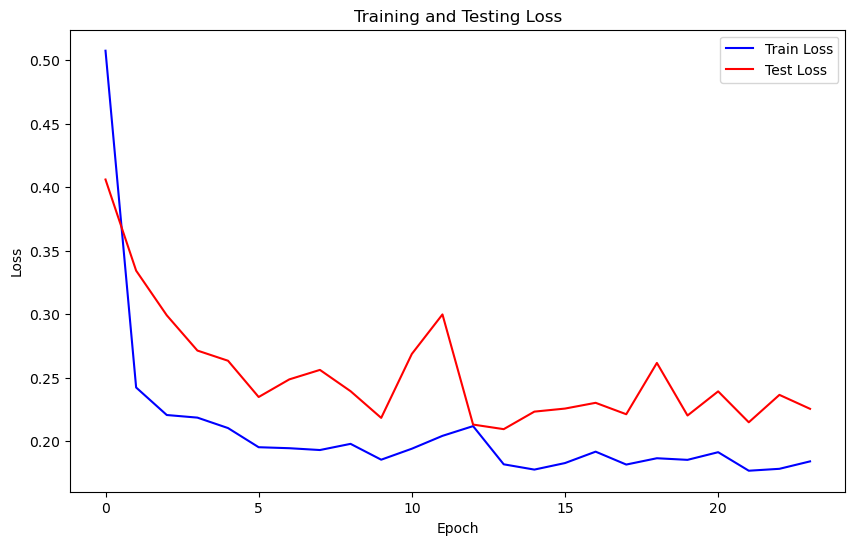

C:\Users\aikey\AppData\Local\Temp\ipykernel_34516\2884238901.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_h4/best_gin_model

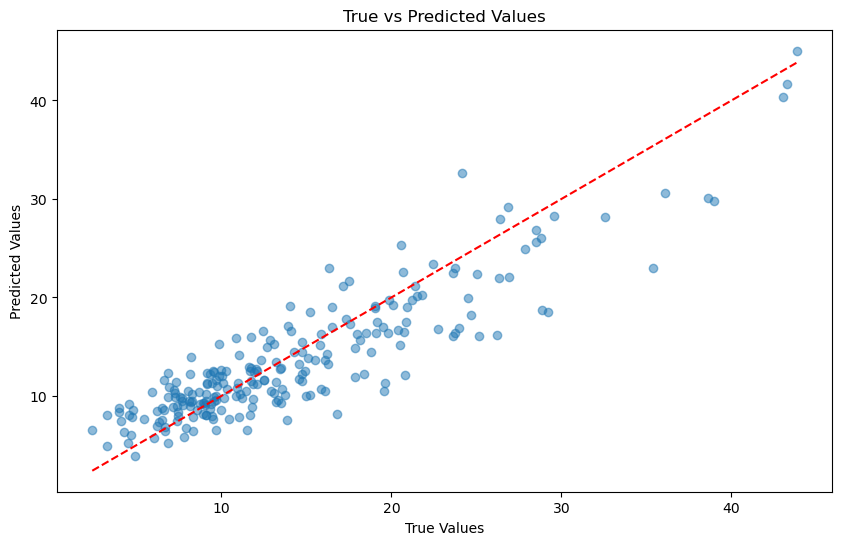

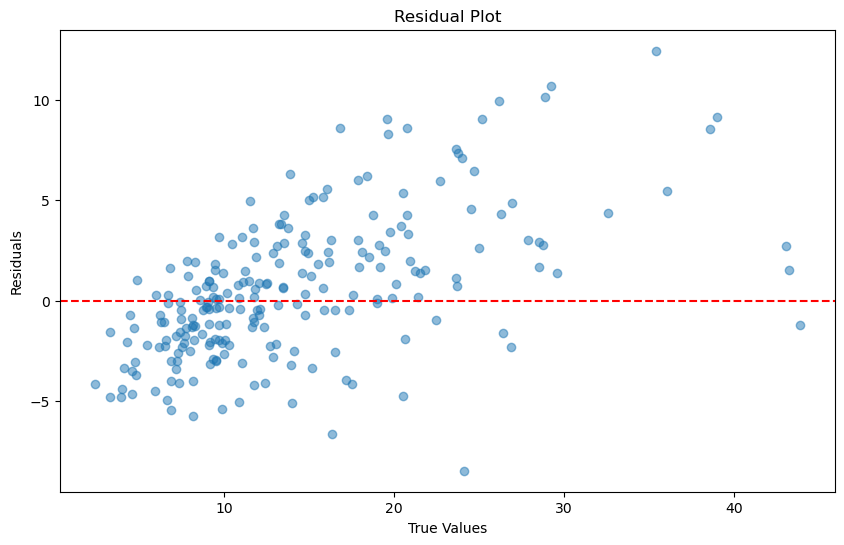

In [8]:
# 绘制训练损失和测试损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# 重新加载最佳模型
model = GIN(H_0, H_1, H_2, H_3,H_4).to(device)
model.load_state_dict(torch.load('weights_h4/best_gin_model.pth'))
model.eval()

# 获取测试集的预测值和真实值
all_y_pred = []
all_y_true = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        # 确保获取的真实值和预测值维度一致
        all_y_pred.extend(standardizer.restore(output).cpu().numpy().flatten())
        all_y_true.extend(data.y.cpu().numpy().flatten())

all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# 绘制预测值与真实值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.5)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

# 计算残差
residuals = all_y_true - all_y_pred

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(all_y_true, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()